In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir
from os.path import join
from json import load
from glob import glob

In [3]:
def get_agent_playthroughs(config):
    playthroughs = []
    for filename in listdir(config.BASE_DIR):
        if filename.startswith('fitagent_playthrough_'):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [4]:
def get_player_playthroughs(config, player_name):
    playthroughs = []
    starts_with_str = f'player_{player_name}_fit_playthrough_{config.NAME}'
    
    for filename in listdir(config.BASE_DIR):
        if filename.startswith(starts_with_str):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [5]:
def heatmap(playthrough_data, graph, filename, bounds):
    max_x, max_y = bounds
    data = np.zeros((max_x + 1, max_y + 1))
    mask = np.ones((max_x + 1, max_y + 1))
    for n in graph.nodes:
        if '__' in n:
            continue
            
        a,b,_ = n.split(',')
        mask[int(a)][int(b)] = 0.0
    
    for run in playthrough_data:
        for segment, _, _, _ in run:
            if '__' in segment:
                continue
                
            a, b, _ = segment.split(',')
            data[int(a)][int(b)] += 1.0
    
    sns.set(rc = {'figure.figsize':(8,4)})
    ax = sns.heatmap(
        data, 
        mask=mask,
        square=True,
        cmap='Blues'
    )
#     ax = sns.heatmap(data, square=True)
    ax.invert_yaxis()
    ax.set_title(filename)
    ax.set_facecolor("gray")
    
    # reduce frequency for xticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # reduce frequency for y ticks
    for ind, label in enumerate(ax.get_yticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.show()

In [6]:
def plot_reward_over_time(playthroughs):
    plot_data = {}
    for filename, data in playthroughs:
        legend_name = filename.split('.')[0].split('_')[-1]
        plot_data[legend_name] = []
        total_reward = 0
        
        for level in data:
            for _, _, _, r in level:
                total_reward += r
            
            plot_data[legend_name].append(total_reward)
    
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_data)
    ax.set_title('Reward over Time')
        
    plt.show()

## Agent :: DungeonGrams

In [7]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


In [8]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

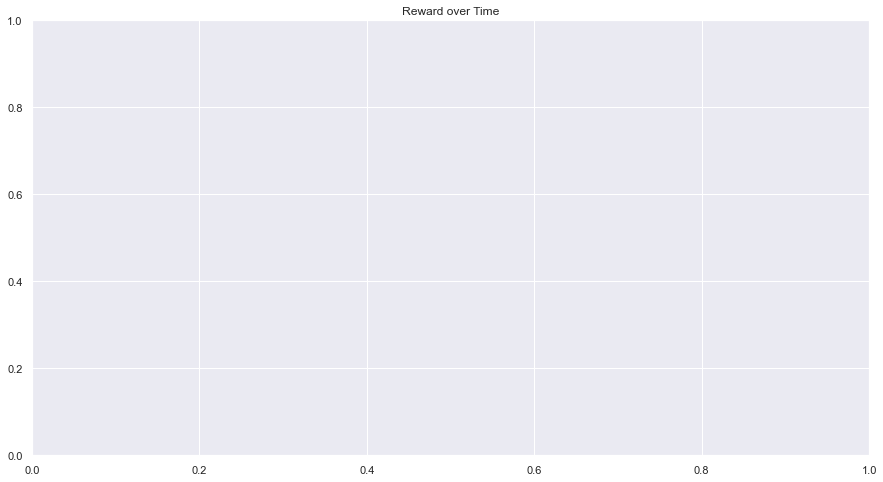

In [9]:
plot_reward_over_time(playthroughs)

## Agent :: Mario

In [10]:
config = Mario
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config)

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


In [11]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

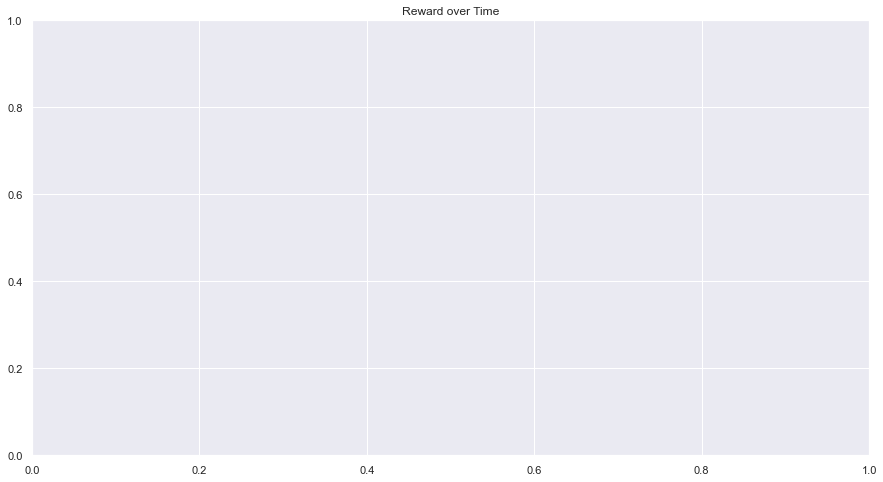

In [12]:
plot_reward_over_time(playthroughs)

## Agent ::  Icarus

In [13]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config)

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


In [14]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

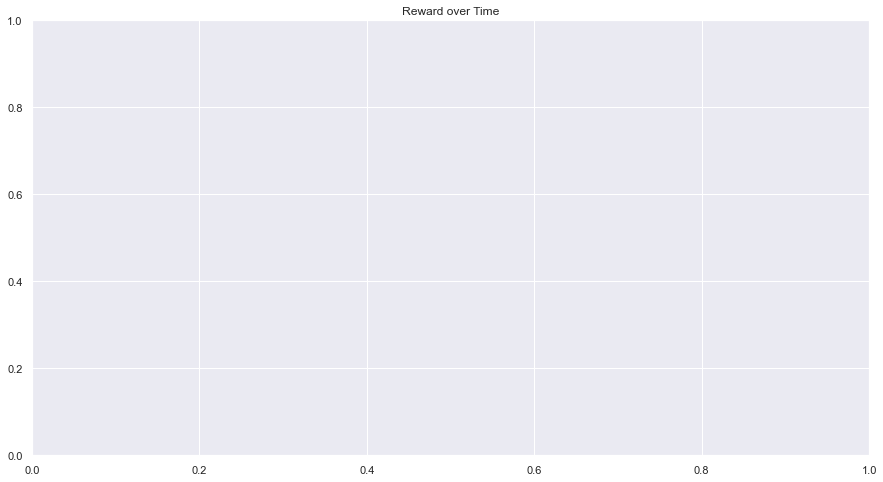

In [15]:
plot_reward_over_time(playthroughs)

# Player Personas

In [16]:
def get_all_player_playthroughs(config):
    playthroughs = []
    for path in glob(join(config.BASE_DIR, 'player_*')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-1].split('.')[0]

        with open(path, 'r') as f:
            playthroughs.append((player, director, load(f)))

    return playthroughs

In [17]:
def get_df(playthroughs):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Total Reward']
    for player, director, run_data in playthroughs:
        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_total_reward = 0

            for lvl in run:
                for _, percent_complete, player_reward, total_reward in lvl:
                    run_percent_complete += percent_complete
                    run_player_reward += player_reward
                    run_total_reward += total_reward
                    
            data.append((
                director, 
                player, 
                run_percent_complete, 
                run_player_reward, 
                run_total_reward))

    return pd.DataFrame(data, columns=labels)\
        .groupby(['Player', 'Director']).agg(['mean', 'std']) \
        .sort_values(by=('Total Reward', 'mean'), ascending=False) \
        .sort_values(by=('Player'))

# Player Personas :: Mario

In [18]:
config = Mario
graph = Utility.get_graph(config, True)
player_playthroughs = get_all_player_playthroughs(config)
df = get_df(player_playthroughs)
# mario_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


Percent Complete             \
                                                         mean        std   
Player                        Director                                     
Bad Player Likes Easy Levels  policy               170.800000   4.494441   
                              GreedyRelative       153.461352  24.881446   
                              random               134.329153  23.042953   
                              q                    101.983890  30.870012   
Bad Player Likes Hard Levels  policy               100.702626  25.073026   
                              GreedyRelative       140.455216  19.167483   
                              q                    157.862693   7.607689   
                              random               162.264676   9.845803   
Good Player Likes Easy Levels policy               169.800000   3.420526   
                              GreedyRelative       166.200000   3.701351   
                              q                    155.824162  11.792617   
                              random               149.879624  16.153084   

                                             Player Reward             \
                                                      mean        std   
Player                        Director                                  
Bad Player Likes Easy Levels  policy            164.845116   3.541947   
                              GreedyRelative    130.889834  21.188279   
                              random            114.379349  24.296997   
                              q                  87.693628  26.691442   
Bad Player Likes Hard Levels  policy             41.611739  12.772048   
                              GreedyRelative     15.428261   8.792826   
                              q                   6.733043   4.824959   
                              random              3.398261   5.871173   
Good Player Likes Easy Levels policy            162.483553   4.452898   
                              GreedyRelative    141.503015   8.719332   
                              q                 117.669916  19.240597   
                              random            112.281615  31.935365   

                                             Total Reward             
                                                     mean        std  
Player                        Director                                
Bad Player Likes Easy Levels  policy           170.094314   3.768604  
                              GreedyRelative   150.950681  22.421634  
                              random           136.213172  21.974269  
                              q                103.224744  29.595961  
Bad Player Likes Hard Levels  policy            88.435384  10.267041  
                              GreedyRelative    61.237248  10.857178  
                              q                 43.740612   9.366648  
                              random            35.939135  20.977646  
Good Player Likes Easy Levels policy           168.248075   4.122104  
                              GreedyRelative   158.644931   5.374730  
                              q                147.697327  12.938139  
                              random           142.972669  24.105685

# Player Personas :: Icarus

In [19]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, 'Bad Player Likes Hard Levels')
df = get_df(playthroughs)
icarus_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


TypeError: get_all_player_playthroughs() takes 1 positional argument but 2 were given

# Player Personas :: DungeonGrams

In [ ]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, 'Bad Player Likes Hard Levels')
df = get_df(playthroughs)
dg_player_persona_table = df.to_latex() # store in case we want it
df